Filtering criteria:

min.cells = 1000 per study
min.gene = 500
min.umi = 1000
max.MT = 30

Authors removed data with DoubletFinder and filtered with 5, 500

In [1]:
library(Seurat)
library(DoubletFinder)
library(HGNChelper)
library(tidyverse)
library(here)

library(CelliD)
library(harmony)
library(future)
source(here("notebooks/helper.R"))

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.4.1 but the current version is 4.4.2; it is recomended that you
reinstall ‘SeuratObject’ as the ABI for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.5 but the current version is 1.7.1; it is recomended
that you reinstall ‘SeuratObject’ as the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Please cite our software :) 
 
 Sehyun Oh et al. HGNChelper: identification and correction of invalid gene symbols for human and mouse. F1000Research 2020, 9:1493. DOI: https://doi.org/10.12688/f1000research.28033.1 
 
 Type `citation('HGNChelper')` for a BibTeX entry.

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot

In [2]:
obj <- readRDS(here('data/wang2024_SA/raw/snRNA_allcell_seurat.rds'))
obj

An object of class Seurat 
39253 features across 90504 samples within 1 assay 
Active assay: RNA (39253 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

In [3]:
cat("Minimum genes:", min(obj$nFeature_RNA), "\n",
    "Minimum UMIs:", min(obj$nCount_RNA), "\n",
    "Minimum MT%:", min(obj$percent.mt), "\n",
    "Maximum MT%:", max(obj$percent.mt), "\n",
    "Number of cells:", ncol(obj))

Minimum genes: 480 
 Minimum UMIs: 586 
 Minimum MT%: 0 
 Maximum MT%: 4.999321 
 Number of cells: 90504

In [6]:
gene.names <- checkGeneSymbols(rownames(obj), unmapped.as.na=FALSE)
rownames(obj) <- make.unique(gene.names$Suggested.Symbol)

Maps last updated on: Sat Nov 16 10:35:32 2024

Warning message in checkGeneSymbols(rownames(obj), unmapped.as.na = FALSE):
“Human gene symbols should be all upper-case except for the 'orf' in open reading frames. The case of some letters was corrected.”
Warning message in checkGeneSymbols(rownames(obj), unmapped.as.na = FALSE):
“x contains non-approved gene symbols”
Warning message:
“Renaming features in v3/v4 assays is not supported”


In [8]:
obj$author <- "wang2024"
obj$donor_id <- obj$orig.ident
obj$method <- "nuclei"
obj$assay <- "DNBelab C Series Single-Cell Library Prep Set"

In [10]:
saveRDS(obj, here("output/wang2024.rds"))

# 2. CellID

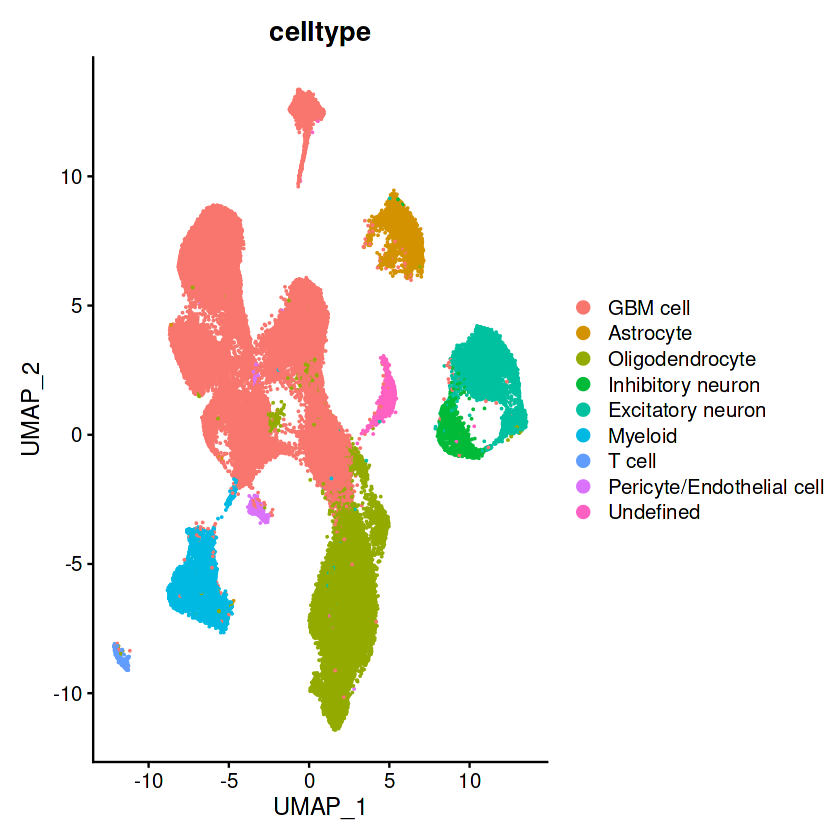

In [12]:
DimPlot(obj, group.by = "celltype")

In [13]:
obj <- obj %>% NormalizeData(verbose = FALSE) %>% FindVariableFeatures(verbose = FALSE) %>% ScaleData(verbose = FALSE) %>% RunMCA(verbose = FALSE) %>% RunPCA(verbose = FALSE)

An object of class Seurat 
39253 features across 90504 samples within 1 assay 
Active assay: RNA (39253 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap